# Model Selection

## Import

In [1]:
import json
import logging
import pickle
import time
import warnings

import numpy as np
import optuna
import pandas as pd
import plotly.graph_objects as go
import smote_variants as sv
import xgboost as xgb
from catboost import CatBoostClassifier
from category_encoders.cat_boost import CatBoostEncoder
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sqlalchemy import create_engine
from tqdm import tqdm_notebook as tqdm
from xgboost import XGBClassifier

logging.getLogger(sv.__name__).setLevel(logging.CRITICAL)
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.options.plotting.backend = "plotly"

## Constants

In [2]:
username = "postgres"
password = "postgres"
host = "localhost"
port = "5432"
db = "db"
chunksize = 1000000

In [3]:
engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{db}")

In [4]:
cities = pd.read_csv("../data/ru_cities.csv")

## Data Selection

In [5]:
def read_data(query, engine, chunksize):
    dfl = []

    for chunk in pd.read_sql(query, con=engine, chunksize=chunksize):
        dfl.append(chunk)

    return pd.concat(dfl, ignore_index=True)

In [6]:
query = """
WITH session_target
AS (SELECT
    h.session_id,
    MAX(CASE
        WHEN h.event_action IN ('sub_car_claim_click', 
                                'sub_car_claim_submit_click', 
                                'sub_open_dialog_click', 
                                'sub_custom_question_submit_click', 
                                'sub_call_number_click', 
                                'sub_callback_submit_click', 
                                'sub_submit_success', 
                                'sub_car_request_submit_click') 
                            THEN 1
        ELSE 0
        END) AS target_action
FROM sber_avtopodpiska.raw_hits h
GROUP BY h.session_id)

SELECT
    s.utm_source,
    s.utm_medium,
    s.utm_campaign,
    s.utm_adcontent,
    s.utm_keyword,
    s.device_category,
    s.device_os,
    s.device_brand,
    s.device_model,
    s.device_screen_resolution,
    s.device_browser,
    s.geo_country,
    s.geo_city,
    t.target_action
FROM sber_avtopodpiska.raw_sessions s
INNER JOIN session_target t
    ON s.session_id = t.session_id
;
"""

In [7]:
df = read_data(query, engine, chunksize)

## Base Preprocess

In [8]:
def pandas_preprocess(df, cities):
    import numpy as np
    import pandas as pd

    return (
        df.assign(
            utm_campaign=lambda _df: _df.utm_campaign.fillna("not_specified"),
            utm_adcontent=lambda _df: _df.utm_adcontent.fillna(
                "not_specified",
            ),
            utm_keyword=lambda _df: _df.utm_keyword.fillna("none"),
            device_category=lambda _df: _df.device_category.apply(
                lambda x: "mobile" if x == "tablet" else x,
            ),
            device_os=lambda _df: _df.device_os.apply(
                lambda x: (
                    "Macintosh"
                    if x == "iOS"
                    else "Windows"
                    if x == "Windows Phone"
                    else "undefined"
                    if pd.isna(x) or x == "(not set)"
                    else "Linux"
                ),
            ),
            device_brand=lambda _df: _df.device_brand.apply(
                lambda x: (
                    "undefined" if pd.isna(x) or x == "(not set)" else x
                ),
            ),
            device_screen_height=lambda _df: _df.device_screen_resolution.apply(
                lambda x: x.split("x")[1],
            ).astype(np.uint16),
            device_browser=lambda _df: _df.device_browser.apply(
                lambda x: ("Safari" if x == "Safari (in-app)" else x),
            ),
            geo_city=lambda _df: _df.geo_city.apply(
                lambda x: "undefined" if x == "(not set)" else x,
            ),
            os_keyword=lambda _df: _df.device_os + "_" + _df.utm_keyword,
        )
        .merge(cities, left_on="geo_city", right_on="name", how="left")
        .drop(
            [
                "name",
                "device_model",
                "device_screen_resolution",
                "device_os",
                "utm_keyword",
            ],
            axis=1,
        )
    )

In [9]:
preprocess = Pipeline(
    steps=[
        (
            "rare_label_encoder",
            RareLabelEncoder(
                n_categories=3,
                variables=[
                    "utm_campaign",
                    "utm_adcontent",
                    "device_brand",
                    "device_browser",
                    "geo_country",
                ],
            ),
        ),
        (
            "binary_encoder",
            OneHotEncoder(
                variables=[
                    "geo_country",
                    "device_category",
                ],
                drop_last_binary=True,
            ),
        ),
        (
            "imputer",
            MeanMedianImputer(
                variables=[
                    "population",
                ],
            ),
        ),
        (
            "category_encoder",
            CatBoostEncoder(),
        ),
        (
            "outliers",
            Winsorizer(
                tail="both",
                variables=[
                    "device_screen_height",
                    "population",
                ],
            ),
        ),
        (
            "scaler",
            SklearnTransformerWrapper(
                StandardScaler(),
                variables=[
                    "device_screen_height",
                    "population",
                ],
            ),
        ),
    ],
)

## Model Builder

In [10]:
def model_builder(
    name,
    y_train,
    weighted=False,
    params={},
):
    class_weights = dict(
        zip(
            np.unique(y_train),
            class_weight.compute_class_weight(
                class_weight="balanced",
                classes=np.unique(y_train),
                y=y_train,
            ),
        )
    )

    sample_weights = class_weight.compute_sample_weight(
        class_weight="balanced",
        y=y_train,
    )

    if name == "LogisticRegression":
        return (
            LogisticRegression(
                class_weight=class_weights if weighted else None,
                **params,
            ),
            {},
        )

    if name == "DecisionTree":
        return (
            DecisionTreeClassifier(
                class_weight=class_weights if weighted else None,
                **params,
            ),
            {},
        )

    if name == "RandomForest":
        return (
            RandomForestClassifier(
                n_jobs=-1,
                class_weight=class_weights if weighted else None,
                **params,
            ),
            {},
        )

    if name == "SVM":
        clf = LinearSVC(
            class_weight=class_weights if weighted else None,
            **params,
        )

        return (
            CalibratedClassifierCV(
                clf,
                method="sigmoid",
                cv=3,
            ),
            {},
        )

    if name == "KNN":
        return (
            KNeighborsClassifier(
                **params,
            ),
            {},
        )

    if name == "XGBoost":
        return (
            XGBClassifier(
                use_label_encoder=False,
                tree_method="gpu_hist",
                **params,
            ),
            dict(
                sample_weight=sample_weights if weighted else None,
                eval_metric="logloss",
            ),
        )

    if name == "LightGBM":
        return (
            LGBMClassifier(
                class_weight=class_weights if weighted else None,
                device="gpu",
                **params,
            ),
            {},
        )

    if name == "CatBoost":
        return (
            CatBoostClassifier(
                task_type="GPU",
                silent=True,
                class_weights=class_weights if weighted else None,
                **params,
            ),
            {},
        )

    if name == "GaussianNB":
        return (
            GaussianNB(
                **params,
            ),
            dict(
                sample_weight=sample_weights if weighted else None,
            ),
        )

    if name == "AdaBoost":
        return (
            AdaBoostClassifier(
                **params,
            ),
            {},
        )

## Split

In [11]:
models = [
    "LogisticRegression",
    "DecisionTree",
    "RandomForest",
    "SVM",
    "KNN",
    "XGBoost",
    "LightGBM",
    "CatBoost",
    "GaussianNB",
    "AdaBoost",
]

resampling = [
    "SMOTE",
    "polynom_fit_SMOTE_mesh",
    "SMOTE_IPF",
    "CCR",
    "G_SMOTE",
    "LVQ_SMOTE",
    "SMOBD",
    "Assembled_SMOTE",
    "SMOTE_TomekLinks",
]

results = {
    "baseline": {},
    "resampled": {},
    "tuned": {},
    "tuned_resampled": {},
    "base_stack": {},
    "stacked_resampled": {},
}

In [12]:
X, y = (
    df.drop(
        columns="target_action",
    ),
    df.target_action,
)

In [13]:
X = pandas_preprocess(X, cities)

In [14]:
skf = StratifiedKFold(n_splits=5)

In [15]:
X_, X_val, y_, y_val = train_test_split(
    X,
    y,
    train_size=0.15,
)

## Baseline Models

In [16]:
for model_name in models:
    for result_set in ["baseline"]:
        results[result_set][model_name] = {}
        results[result_set][model_name]["fit_time"] = []
        results[result_set][model_name]["roc_auc"] = []

In [17]:
outer = tqdm(skf.split(X_, y_), desc="Cross-val")

for train_index, test_index in outer:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = preprocess.fit_transform(X_train, y_train)
    X_test = preprocess.transform(X_test)

    inner = tqdm(models, leave=False)

    for model_name in inner:
        inner.set_description(model_name)

        start = time.time()

        model, params = model_builder(model_name, y_train, weighted=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train, **params)

        results["baseline"][model_name]["fit_time"].append(time.time() - start)

        results["baseline"][model_name]["roc_auc"].append(
            roc_auc_score(
                y_test,
                model.predict_proba(X_test)[:, 1],
            )
        )

Cross-val: 0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

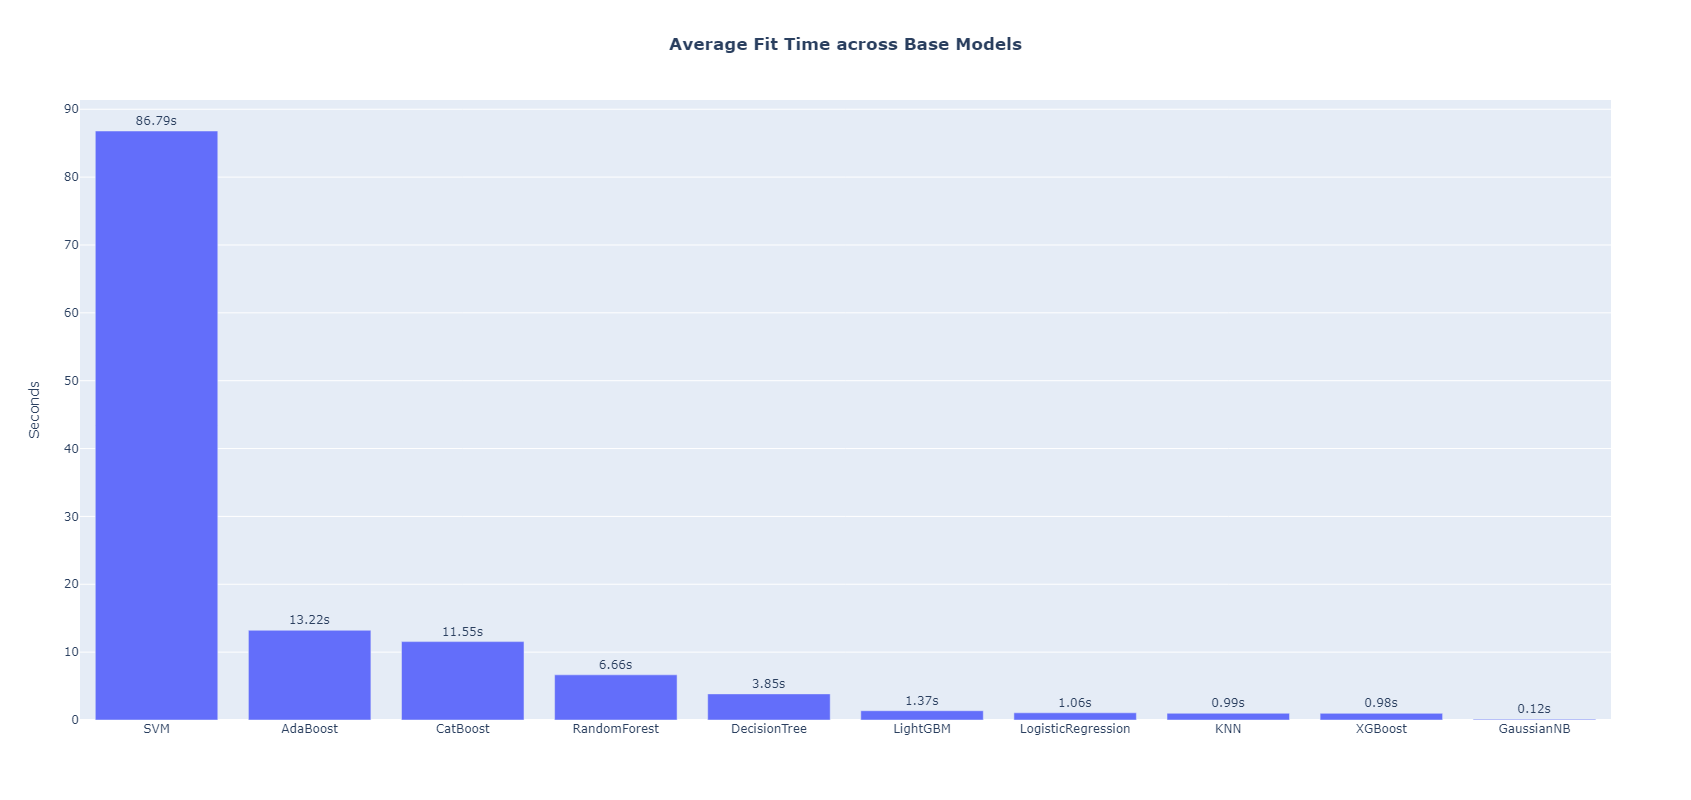

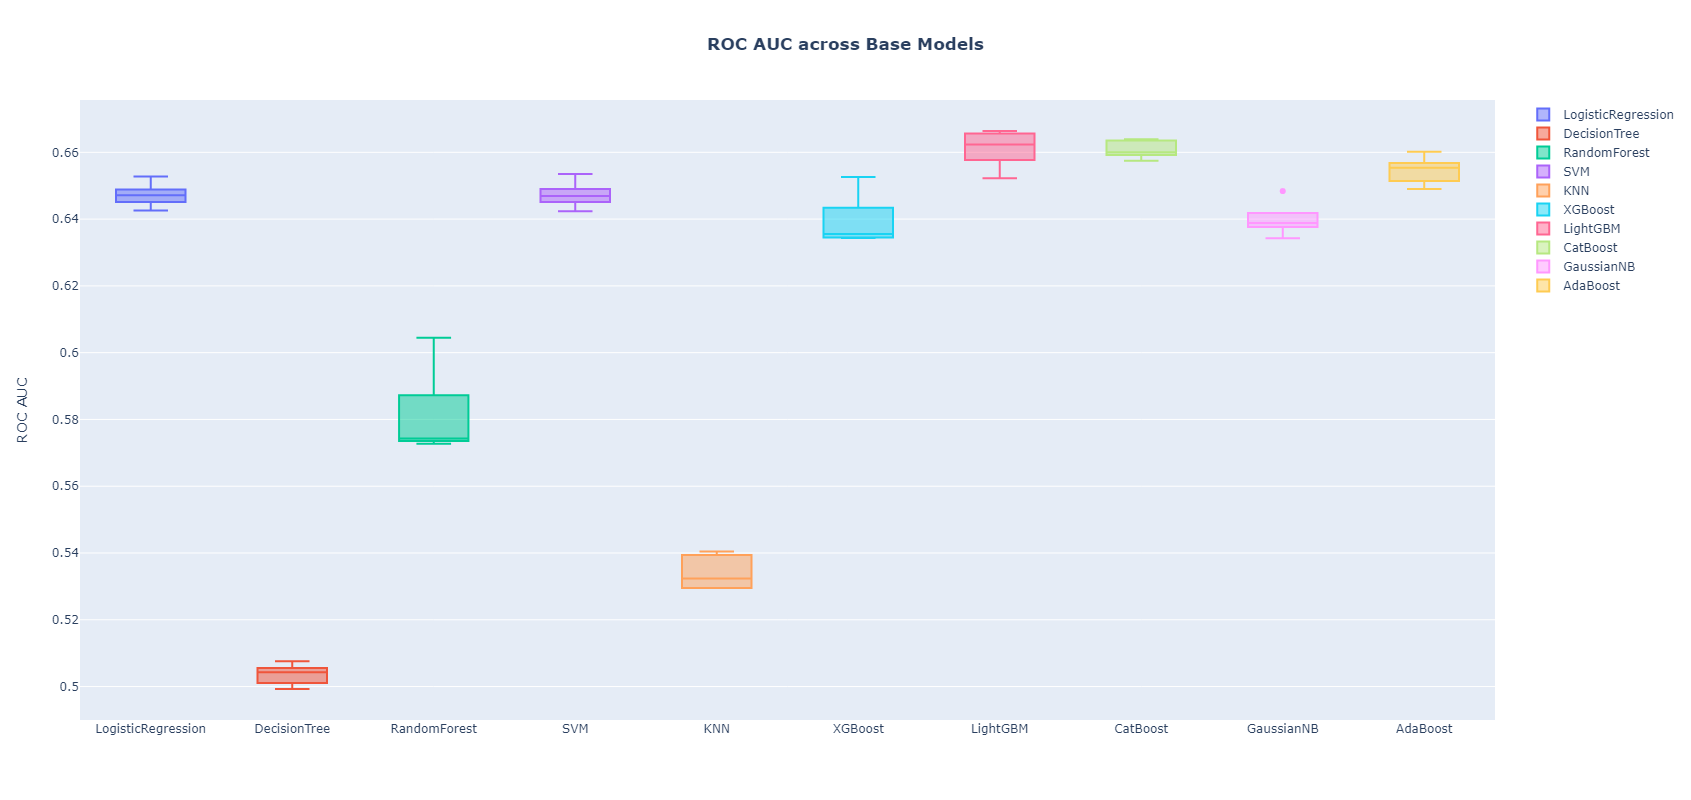

In [100]:
fit_time_data = pd.DataFrame.from_dict(
    {
        model: np.mean(data["fit_time"])
        for model, data in results["baseline"].items()
    },
    orient="index",
).sort_values(by=0, ascending=False)

roc_auc_data = {
    model: data["roc_auc"] for model, data in results["baseline"].items()
}


fig1 = go.Figure(
    go.Bar(
        x=list(fit_time_data.index),
        y=list(fit_time_data.values.flatten()),
        text=[str(round(i, 2)) + "s" for i in fit_time_data.values.flatten()],
        textposition="outside",
    )
)

fig1.update_layout(
    title="<b>Average Fit Time across Base Models</b>",
    title_x=0.5,
    yaxis_title="Seconds",
    height=800,
    hovermode="x unified",
)

fig2 = go.Figure()

for model, roc_aucs in roc_auc_data.items():
    fig2.add_trace(go.Box(y=roc_aucs, name=model))

fig2.update_layout(
    title="<b>ROC AUC across Base Models<b>",
    title_x=0.5,
    height=800,
    hovermode="x unified",
    yaxis_title="ROC AUC",
)

fig1.show()
fig2.show()

## Resampling

In [20]:
for model_name in models:
    for result_set in ["resampled"]:
        for resampling_method in resampling:
            results[result_set][
                "_".join(
                    [
                        model_name,
                        resampling_method,
                    ]
                )
            ] = {}
            results[result_set][
                "_".join(
                    [
                        model_name,
                        resampling_method,
                    ]
                )
            ]["fit_time"] = []
            results[result_set][
                "_".join(
                    [
                        model_name,
                        resampling_method,
                    ]
                )
            ]["roc_auc"] = []

In [21]:
outer = tqdm(skf.split(X_, y_), desc="Cross-val")


for train_index, test_index in outer:
    resample = tqdm(resampling, leave=False)

    for resampling_method in resample:
        resample.set_description(resampling_method)

        resampler = getattr(sv, resampling_method)()

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train = preprocess.fit_transform(X_train, y_train)
        X_train, y_train = resampler.sample(X_train.values, y_train.values)

        X_test = preprocess.transform(X_test).values

        inner = tqdm(models, leave=False)

        for model_name in inner:
            inner.set_description(model_name)

            start = time.time()

            model, params = model_builder(model_name, y_train, weighted=False)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train, y_train, **params)

            results["resampled"][model_name + "_" + resampling_method][
                "fit_time"
            ].append(time.time() - start)

            results["resampled"][model_name + "_" + resampling_method][
                "roc_auc"
            ].append(
                roc_auc_score(
                    y_test,
                    model.predict_proba(X_test)[:, 1],
                )
            )

Cross-val: 0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
rows = []

for key in results["resampled"].keys():
    rows.extend(
        [
            [*key.split("_", 1), fit_time, roc_auc]
            for fit_time, roc_auc in zip(
                results["resampled"][key]["fit_time"],
                results["resampled"][key]["roc_auc"],
            )
        ]
    )

In [23]:
df_resampled_res = pd.DataFrame(
    rows, columns=["model", "resampling", "fit_time", "roc_auc"]
)

In [24]:
groupby_resampled = (
    df_resampled_res.groupby(["model", "resampling"]).mean().reset_index()
)

In [26]:
groupby_resampled = groupby_resampled.sort_values(
    by="fit_time", ascending=False
)

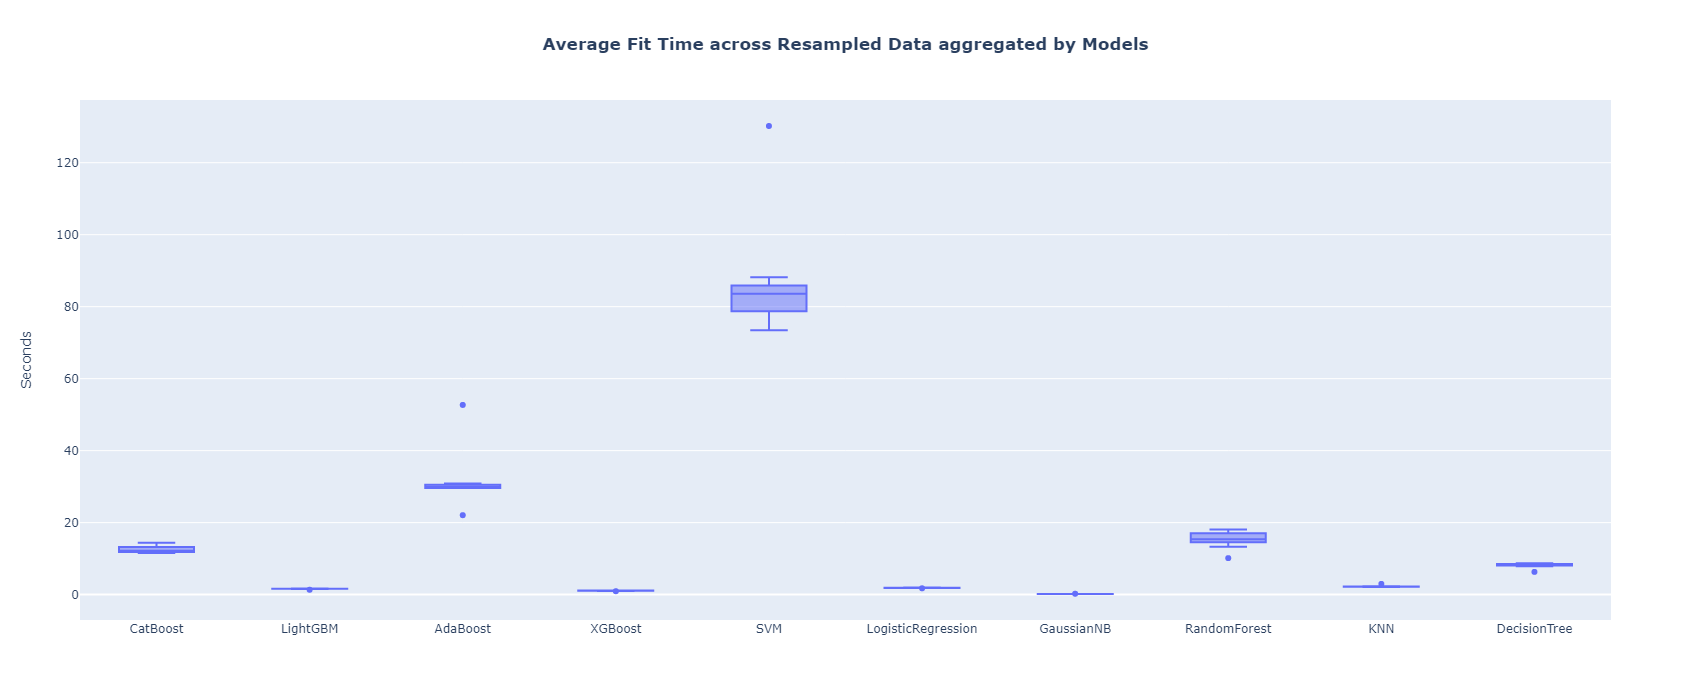

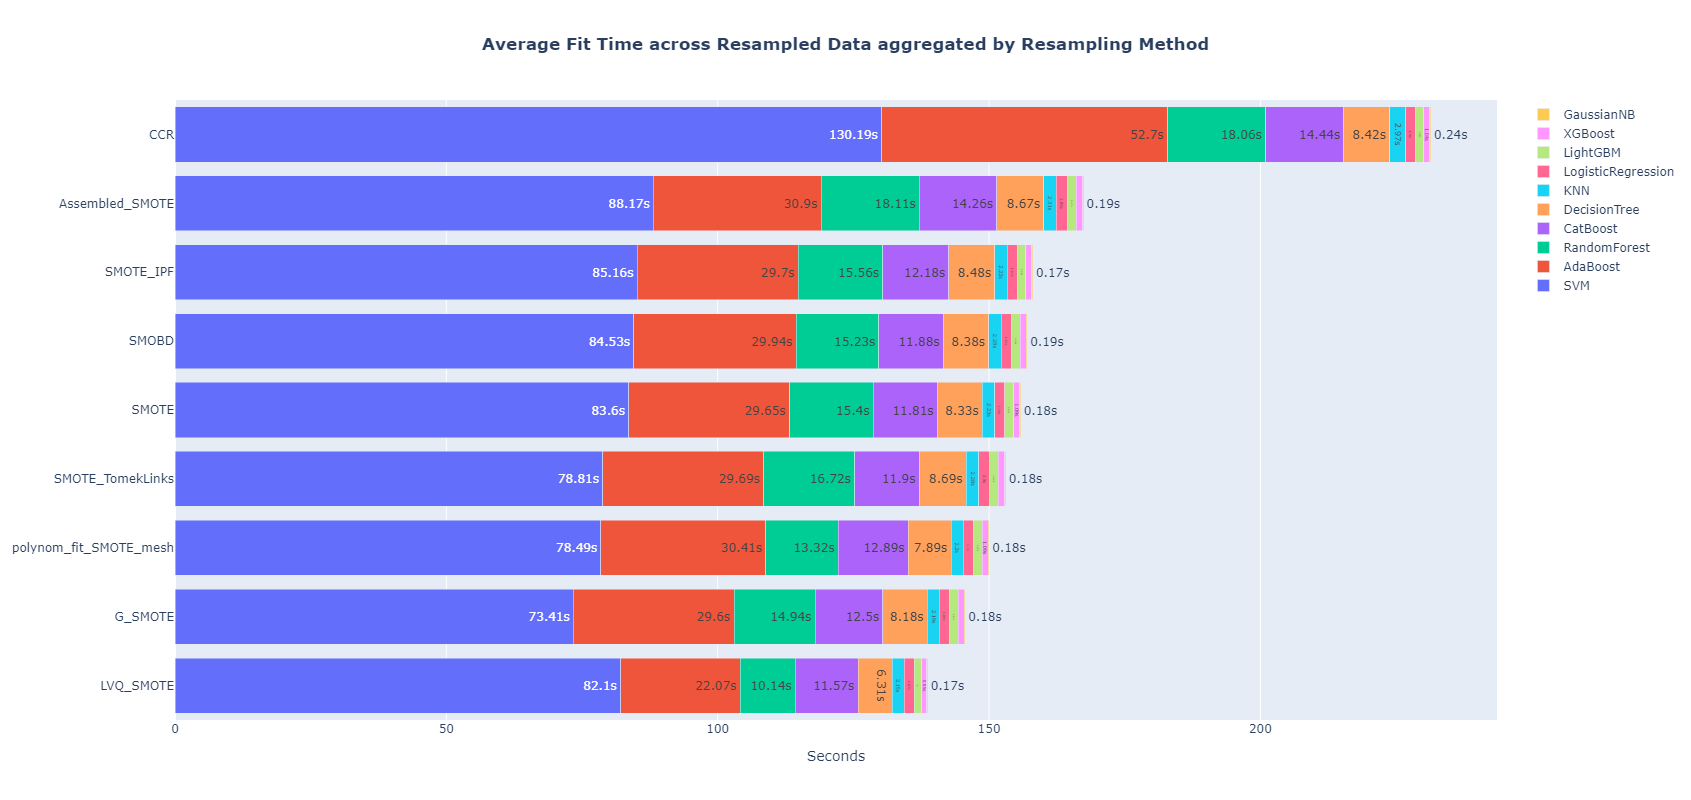

In [87]:
fig = go.Figure(
    [
        go.Box(
            x=groupby_resampled["model"],
            y=groupby_resampled["fit_time"],
        )
    ]
)

fig.update_layout(
    height=700,
    hovermode="x unified",
    yaxis_title="Seconds",
    title="<b>Average Fit Time across Resampled Data aggregated by Models</b>",
    title_x=0.5,
)

fig.show()

fig = go.Figure(
    [
        go.Bar(
            y=groupby_resampled.query("model == @model")["resampling"],
            x=groupby_resampled.query("model == @model")["fit_time"],
            text=[
                str(round(i, 2)) + "s"
                for i in groupby_resampled.query("model == @model")["fit_time"]
            ],
            name=model,
            orientation="h",
        )
        for model in groupby_resampled.groupby("model")
        .fit_time.sum()
        .sort_values(ascending=False)
        .index
    ]
)

fig.update_layout(
    barmode="stack",
    yaxis=dict(
        categoryorder="total ascending",
    ),
    height=800,
    hovermode="y unified",
    title="<b>Average Fit Time across Resampled Data aggregated by Resampling Method</b>",
    title_x=0.5,
    xaxis_title="Seconds",
)

fig.show()

In [28]:
groupby_resampled = groupby_resampled.sort_values(by="roc_auc", ascending=False)

In [29]:
# Top 3 resampling techniques for each model
top_3 = (
    df_resampled_res.groupby(["model", "resampling"], as_index=False)
    .roc_auc.mean()
    .iloc[
        df_resampled_res.groupby(["model", "resampling"], as_index=False)
        .roc_auc.mean()
        .groupby("model")
        .roc_auc.nlargest(3)
        .reset_index()["level_1"]
    ]
)

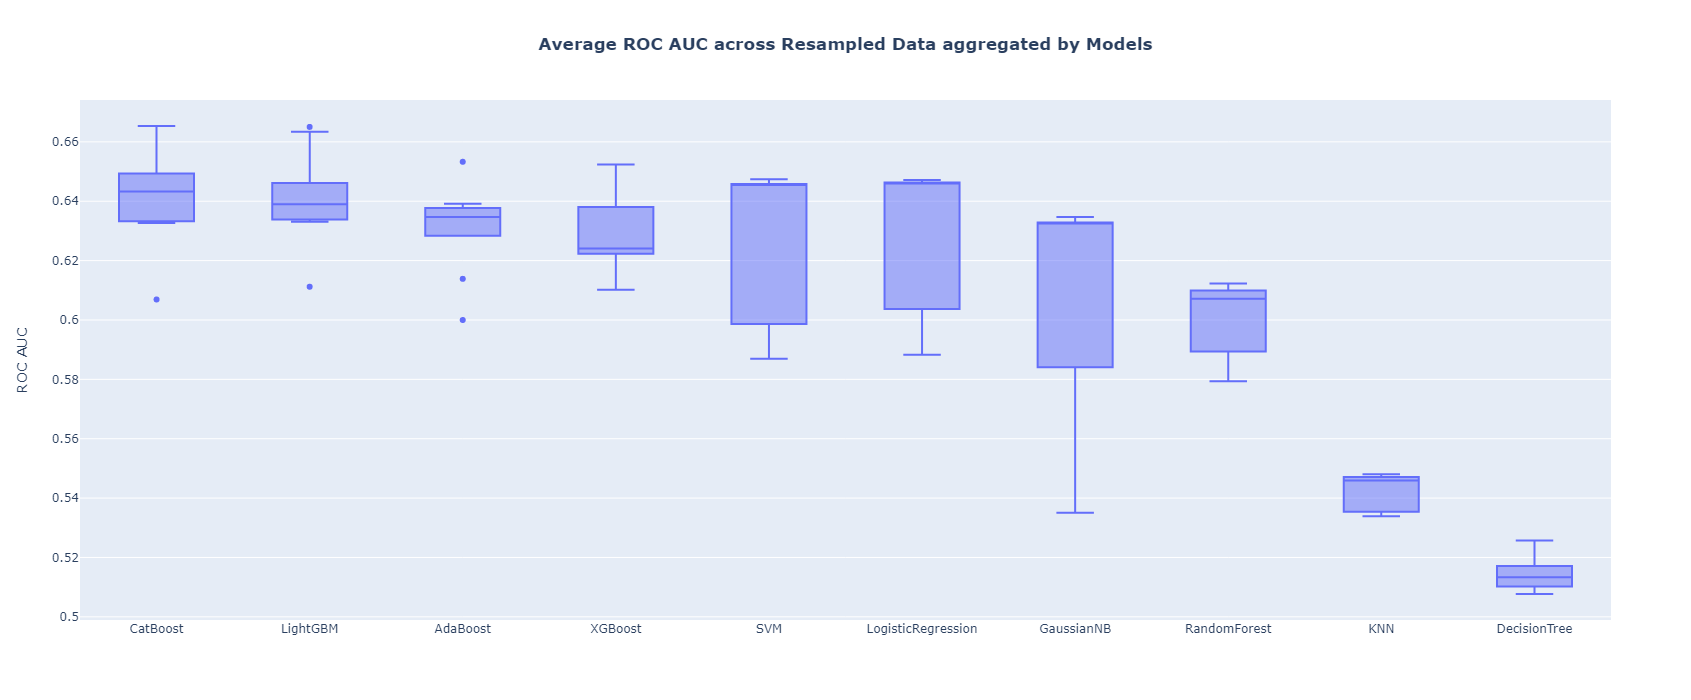

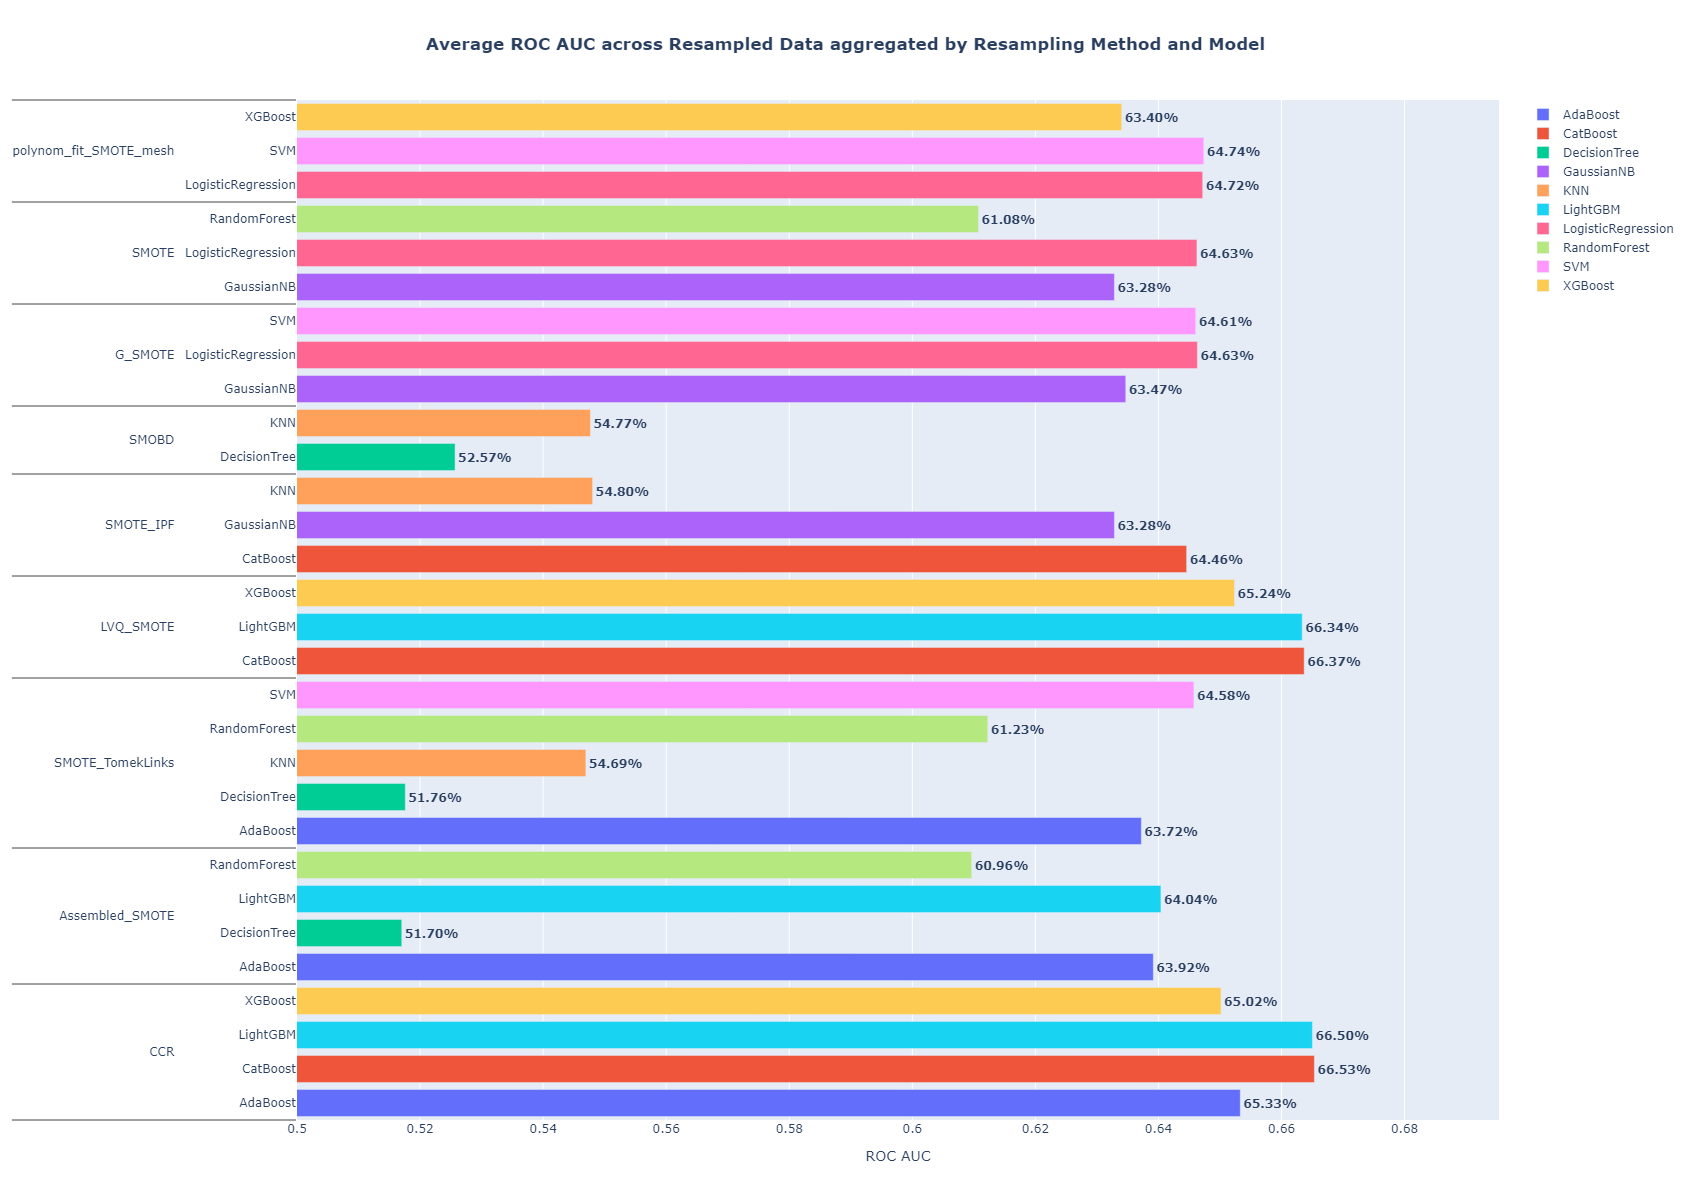

In [91]:
fig = go.Figure(
    [
        go.Box(
            x=groupby_resampled["model"],
            y=groupby_resampled["roc_auc"],
        )
    ]
)

fig.update_layout(
    height=700,
    hovermode="x unified",
    title="<b>Average ROC AUC across Resampled Data aggregated by Models</b>",
    title_x=0.5,
    yaxis_title="ROC AUC",
)

fig.show()

fig = go.Figure(
    [
        go.Bar(
            y=top_3.query("model == @model")[["resampling", "model"]].T,
            x=top_3.query("model == @model")["roc_auc"],
            text=[
                f"<b>{i*100:.2f}%</b>"
                for i in top_3.query("model == @model")["roc_auc"]
            ],
            textposition="outside",
            name=model,
            orientation="h",
        )
        for model in top_3.model.unique()
    ]
)

fig.update_layout(
    xaxis=dict(
        range=[0.5, top_3.roc_auc.max() + 0.03],
        title="ROC AUC",
    ),
    yaxis=dict(categoryorder="category descending"),
    barmode="group",
    height=1200,
    hovermode="y unified",
    title="<b>Average ROC AUC across Resampled Data aggregated by Resampling Method and Model</b>",
    title_x=0.5,
)

fig.show()

<div style='font-size: 20px'>
    Overall, it can be observed that CCR is a good method for boosting models and performed slightly better than LVQ_SMOTE, but took twice as long to train, while Assembled_SMOTE and SMOTE_TomekLinks also performed well on various model types.
</div>

## Tuning objectives

In [31]:
class Objectives:
    # TODO: change gpu objectives to cpu if run in containers

    def __init__(self, X_train, y_train, X_test, y_test, weighted=False):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.weighted = weighted

        self.sample_weights = class_weight.compute_sample_weight(
            class_weight="balanced",
            y=self.y_train,
        )

        self.class_weights = dict(
            zip(
                np.unique(self.y_train),
                class_weight.compute_class_weight(
                    class_weight="balanced",
                    classes=np.unique(self.y_train),
                    y=self.y_train,
                ),
            )
        )

    def objective_XGBoost(self, trial):
        params = {
            "verbosity": 0,
            "objective": "binary:logistic",
            "tree_method": "gpu_hist",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "n_estimators": trial.suggest_int("n_estimators", 100, 350),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "colsample_bytree": trial.suggest_float(
                "colsample_bytree", 0.2, 1.0
            ),
            "use_label_encoder": False,
        }

        if params["booster"] in ["gbtree", "dart"]:
            params["max_depth"] = trial.suggest_int("max_depth", 3, 15, step=2)
            params["min_child_weight"] = trial.suggest_int(
                "min_child_weight", 2, 10
            )
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical(
                "sample_type", ["uniform", "weighted"]
            )
            params["normalize_type"] = trial.suggest_categorical(
                "normalize_type", ["tree", "forest"]
            )
            params["rate_drop"] = trial.suggest_float(
                "rate_drop", 1e-8, 1.0, log=True
            )
            params["skip_drop"] = trial.suggest_float(
                "skip_drop", 1e-8, 1.0, log=True
            )

        clf = XGBClassifier(**params)
        clf.fit(
            self.X_train,
            self.y_train,
            sample_weight=self.sample_weights if self.weighted else None,
        )
        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_LogisticRegression(self, trial):
        params = {
            "C": trial.suggest_float("C", 1e-10, 1e10, log=True),
            "tol": trial.suggest_float("tol", 1e-10, 1e2),
            "solver": trial.suggest_categorical(
                "solver",
                [
                    "lbfgs",
                    "liblinear",
                    "newton-cg",
                    "newton-cholesky",
                    "sag",
                    "saga",
                ],
            ),
            "n_jobs": -1,
            "max_iter": 1000,
        }

        if params["solver"] in ["lbfgs", "newton-cg", "newton-cholesky", "sag"]:
            params["penalty"] = "l2"

        if params["solver"] in ["liblinear", "saga"]:

            params["penalty"] = (
                trial.suggest_categorical("penalty", ["l1", "l2"]),
            )

        clf = LogisticRegression(
            class_weight=self.class_weights if self.weighted else None
        )
        clf.fit(self.X_train, self.y_train)
        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_GaussianNB(self, trial):
        params = {
            "var_smoothing": trial.suggest_categorical(
                "var_smoothing", [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]
            )
        }

        clf = GaussianNB(**params)
        clf.fit(
            self.X_train,
            self.y_train,
            sample_weight=self.sample_weights if self.weighted else None,
        )

        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_AdaBoost(self, trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 25, 350),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
        }

        clf = AdaBoostClassifier(**params)
        clf.fit(self.X_train, self.y_train)

        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_RandomForest(self, trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 25, 350),
            "criterion": trial.suggest_categorical(
                "criterion", ["gini", "entropy", "log_loss"]
            ),
            "max_depth": trial.suggest_int("max_depth", 3, 15, step=2),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "min_weight_fraction_leaf": trial.suggest_float(
                "min_weight_fraction_leaf", 0, 0.5
            ),
            "max_features": trial.suggest_categorical(
                "max_features", ["sqrt", "log2"]
            ),
            "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 10),
            "bootstrap": True,
            "oob_score": trial.suggest_categorical("oob_score", [True, False]),
            "n_jobs": -1,
        }

        clf = RandomForestClassifier(
            class_weight=self.class_weights if self.weighted else None, **params
        )
        clf.fit(self.X_train, self.y_train)

        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_CatBoost(self, trial):
        params = {
            "iterations": trial.suggest_int("iterations", 100, 500),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2),
            "depth": trial.suggest_int("depth", 3, 15, step=2),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1),
            "random_strength": trial.suggest_float(
                "random_strength", 1e-8, 10.0, log=True
            ),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli"]
            ),
            "grow_policy": trial.suggest_categorical(
                "grow_policy", ["SymmetricTree", "Lossguide"]
            ),
            "max_bin": trial.suggest_int("max_bin", 2, 10),
            "task_type": "GPU",
            "silent": True,
            "eval_metric": "AUC",
            "od_type": trial.suggest_categorical(
                "od_type", ["IncToDec", "Iter"]
            ),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "allow_writing_files": False,
        }

        if params["grow_policy"] == "Lossguide":
            params["max_leaves"] = trial.suggest_int("max_leaves", 2, 10)
            params["min_data_in_leaf"] = trial.suggest_int(
                "min_data_in_leaf", 2, 10
            )

        if params["bootstrap_type"] == "Bayesian":
            params["bagging_temperature"] = trial.suggest_float(
                "bagging_temperature", 0, 10
            )

        if params["bootstrap_type"] == "Bernoulli":
            params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        clf = CatBoostClassifier(
            class_weights=self.class_weights if self.weighted else None,
            **params
        )
        clf.fit(self.X_train, self.y_train)

        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_LightGBM(self, trial):
        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            "n_estimators": trial.suggest_int("n_estimators", 100, 350),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
            "max_depth": trial.suggest_int("max_depth", 3, 15, step=2),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
            "colsample_bytree": trial.suggest_float(
                "colsample_bytree", 0.2, 1.0
            ),
            "reg_alpha": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float(
                "lambda_l2", 1e-8, 10.0, log=True
            ),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "n_jobs": -1,
            "device": "gpu",
        }

        clf = LGBMClassifier(
            class_weight=self.class_weights if self.weighted else None, **params
        )
        clf.fit(self.X_train, self.y_train)

        score = roc_auc_score(self.y_test, clf.predict_proba(self.X_test)[:, 1])

        return score

    def objective_SVM(self, trial):
        params = {
            "tol": trial.suggest_float("tol", 1e-5, 1e-1),
            "C": trial.suggest_float("C", 1e-3, 1000),
            "dual": False,
        }

        clf = LinearSVC(
            class_weight=self.class_weights if self.weighted else None, **params
        )

        calibrated_svc = CalibratedClassifierCV(
            clf,
            method="sigmoid",
            cv=3,
        )

        calibrated_svc.fit(self.X_train, self.y_train)

        score = roc_auc_score(
            self.y_test, calibrated_svc.predict_proba(self.X_test)[:, 1]
        )

        return score

## Tuned models without resampling

In [32]:
models.remove("KNN")
models.remove("DecisionTree")

In [33]:
for model in models:
    results["tuned"][model] = {
        "roc_auc": 0,
        "params": {},
    }

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_,
    y_,
)

X_train = preprocess.fit_transform(X_train, y_train)
X_test = preprocess.transform(X_test)

In [35]:
objectives = Objectives(X_train, y_train, X_test, y_test, weighted=True)
sampler = optuna.samplers.TPESampler()
outer = tqdm(models)

for model in outer:
    outer.set_description(model)

    objective_wrapper = lambda trial: getattr(objectives, "objective_" + model)(
        trial
    )

    study = optuna.create_study(direction="maximize", sampler=sampler)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        study.optimize(objective_wrapper, n_trials=25, timeout=600)

    results["tuned"][model]["params"] = study.best_trial.params
    results["tuned"][model]["roc_auc"] = study.best_trial.value

  0%|          | 0/8 [00:00<?, ?it/s]

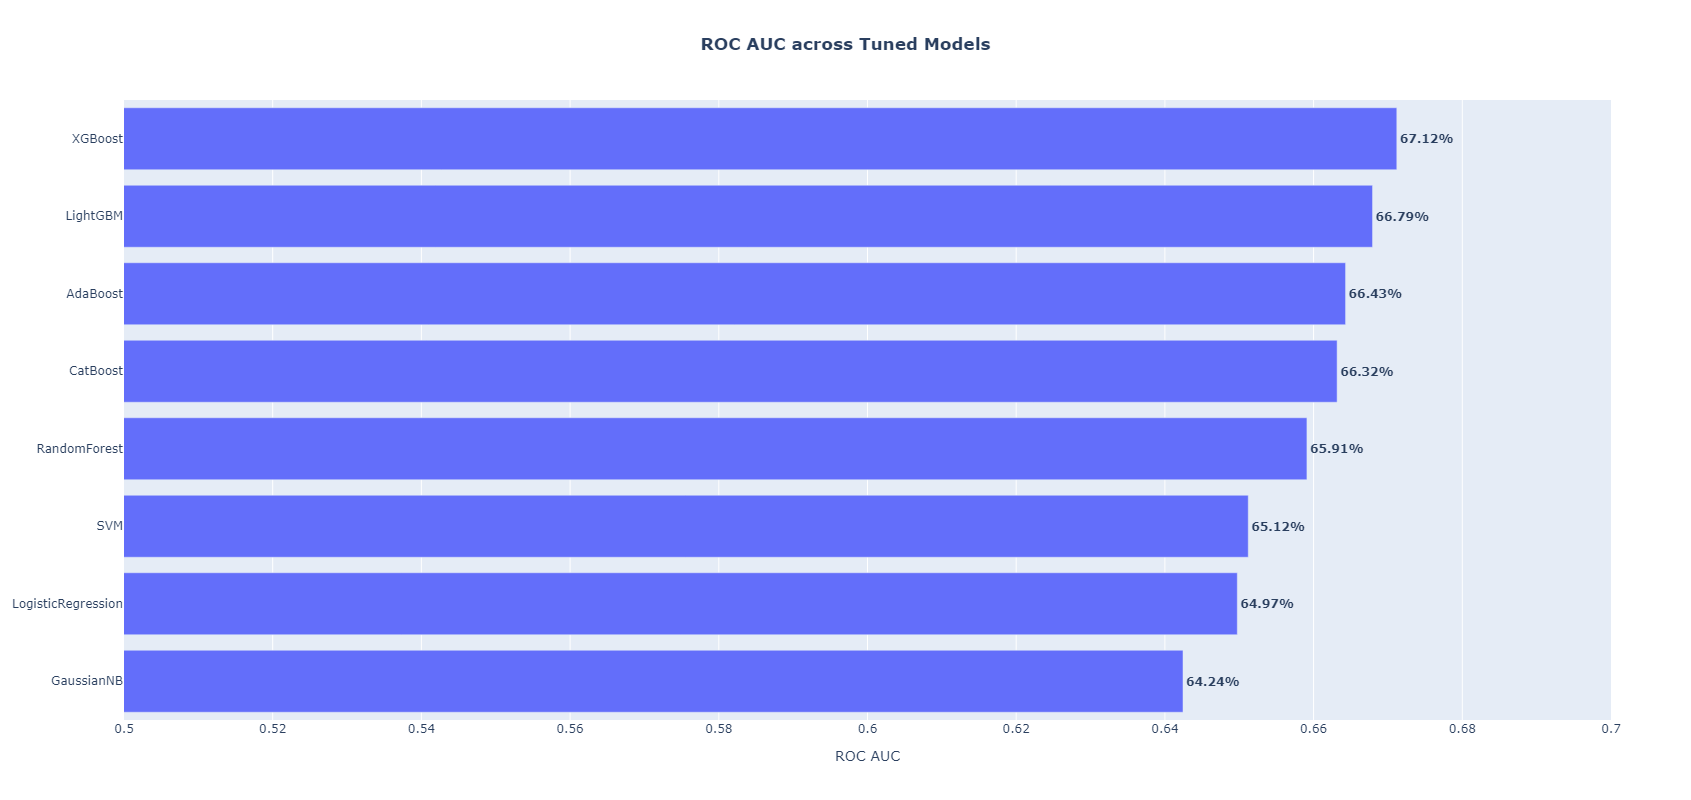

In [90]:
scores = pd.DataFrame.from_dict(results["tuned"], orient="index")

fig = go.Figure(
    go.Bar(
        y=list(scores.index),
        x=list(scores.roc_auc),
        orientation="h",
        text=[f"<b>{i*100:.2f}%</b>" for i in scores.roc_auc],
        textposition="outside",
    )
)

fig.update_layout(
    title="<b>ROC AUC across Tuned Models</b>",
    title_x=0.5,
    xaxis=dict(range=(0.5, 0.7), title="ROC AUC"),
    height=800,
    hovermode="y unified",
    yaxis=dict(categoryorder="total ascending"),
)

## Tuned models with resampling

In [42]:
for model in models:
    results["tuned_resampled"][model] = {
        "roc_auc": 0,
        "params": {},
    }

In [38]:
resampling_dict = {
    "LogisticRegression": sv.SMOTE,
    "RandomForest": sv.SMOTE_TomekLinks,
    "SVM": sv.SMOTE_TomekLinks,
    "XGBoost": sv.LVQ_SMOTE,
    "LightGBM": sv.LVQ_SMOTE,
    "CatBoost": sv.LVQ_SMOTE,
    "GaussianNB": sv.SMOTE,
    "AdaBoost": sv.LVQ_SMOTE,
}

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X_,
    y_,
)

X_train = preprocess.fit_transform(X_train, y_train)
X_test = preprocess.transform(X_test)

In [43]:
sampler = optuna.samplers.TPESampler()
outer = tqdm(models)

for model in outer:
    outer.set_description(model)

    objective_wrapper = lambda trial: getattr(objectives, "objective_" + model)(
        trial
    )

    resampler = resampling_dict[model]()

    X_train_resampled, y_train_resampled = resampler.sample(
        X_train.values, y_train.values
    )

    objectives = Objectives(
        X_train_resampled, y_train_resampled, X_test, y_test, weighted=False
    )

    study = optuna.create_study(direction="maximize", sampler=sampler)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        study.optimize(objective_wrapper, n_trials=25, timeout=600)

    results["tuned_resampled"][model]["params"] = study.best_trial.params
    results["tuned_resampled"][model]["roc_auc"] = study.best_trial.value

  0%|          | 0/8 [00:00<?, ?it/s]

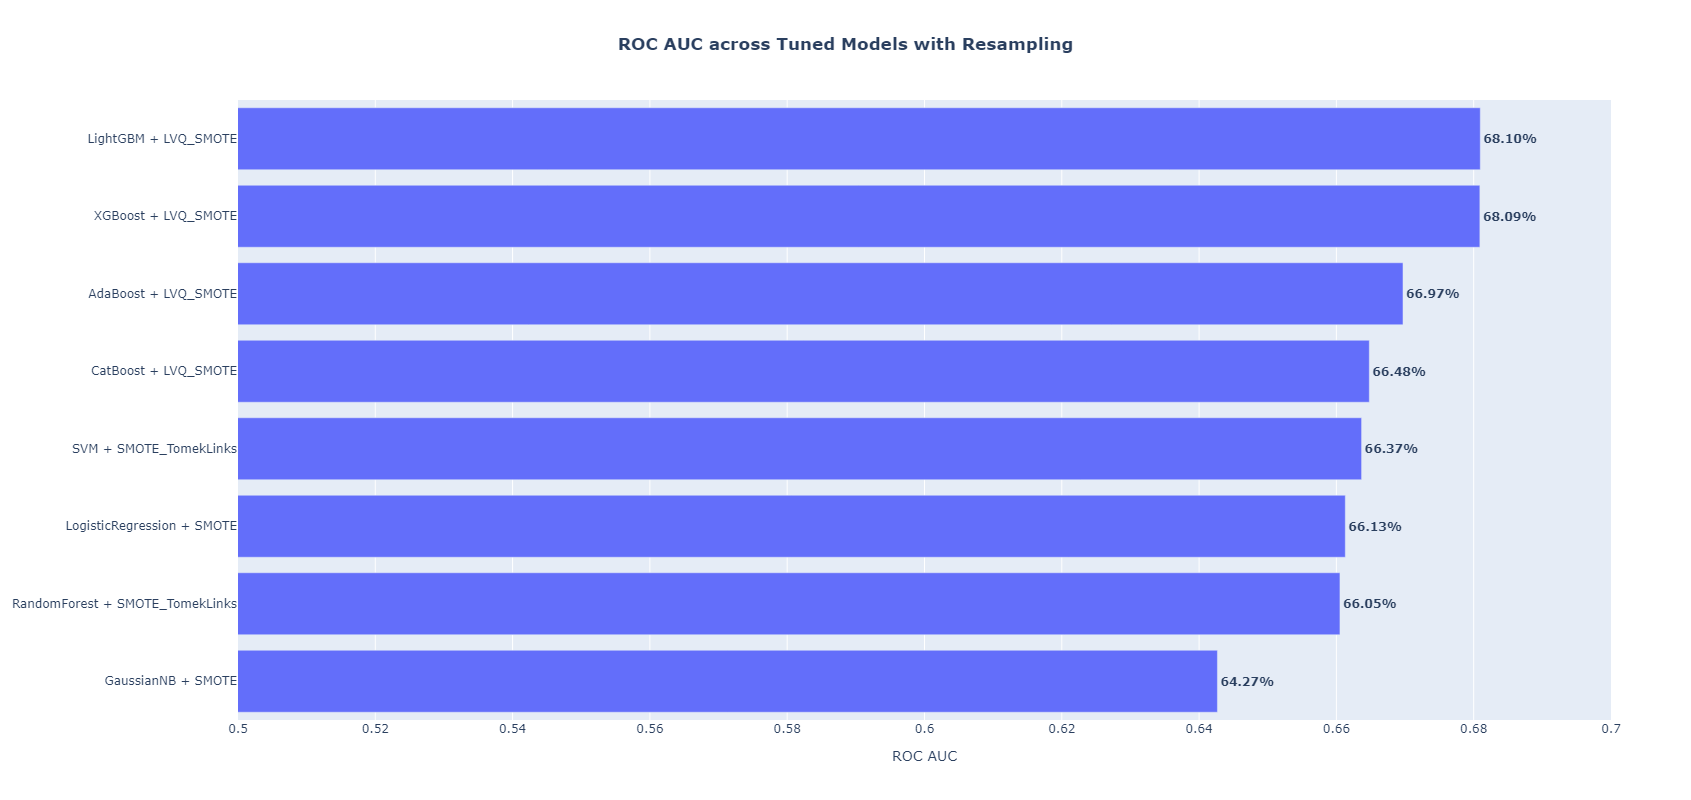

In [89]:
scores = pd.DataFrame.from_dict(results["tuned_resampled"], orient="index")
scores.index = list(
    map(lambda x: x + " + " + resampling_dict[x].__name__, scores.index)
)

fig = go.Figure(
    go.Bar(
        x=scores.roc_auc,
        y=scores.index,
        orientation="h",
        text=[f"<b>{i*100:.2f}%</b>" for i in scores.roc_auc],
        textposition="outside",
    )
)

fig.update_layout(
    title="<b>ROC AUC across Tuned Models with Resampling</b>",
    title_x=0.5,
    xaxis_title="ROC AUC",
    height=800,
    xaxis=dict(range=[0.5, 0.7]),
    hovermode="y unified",
    yaxis=dict(categoryorder="total ascending"),
)

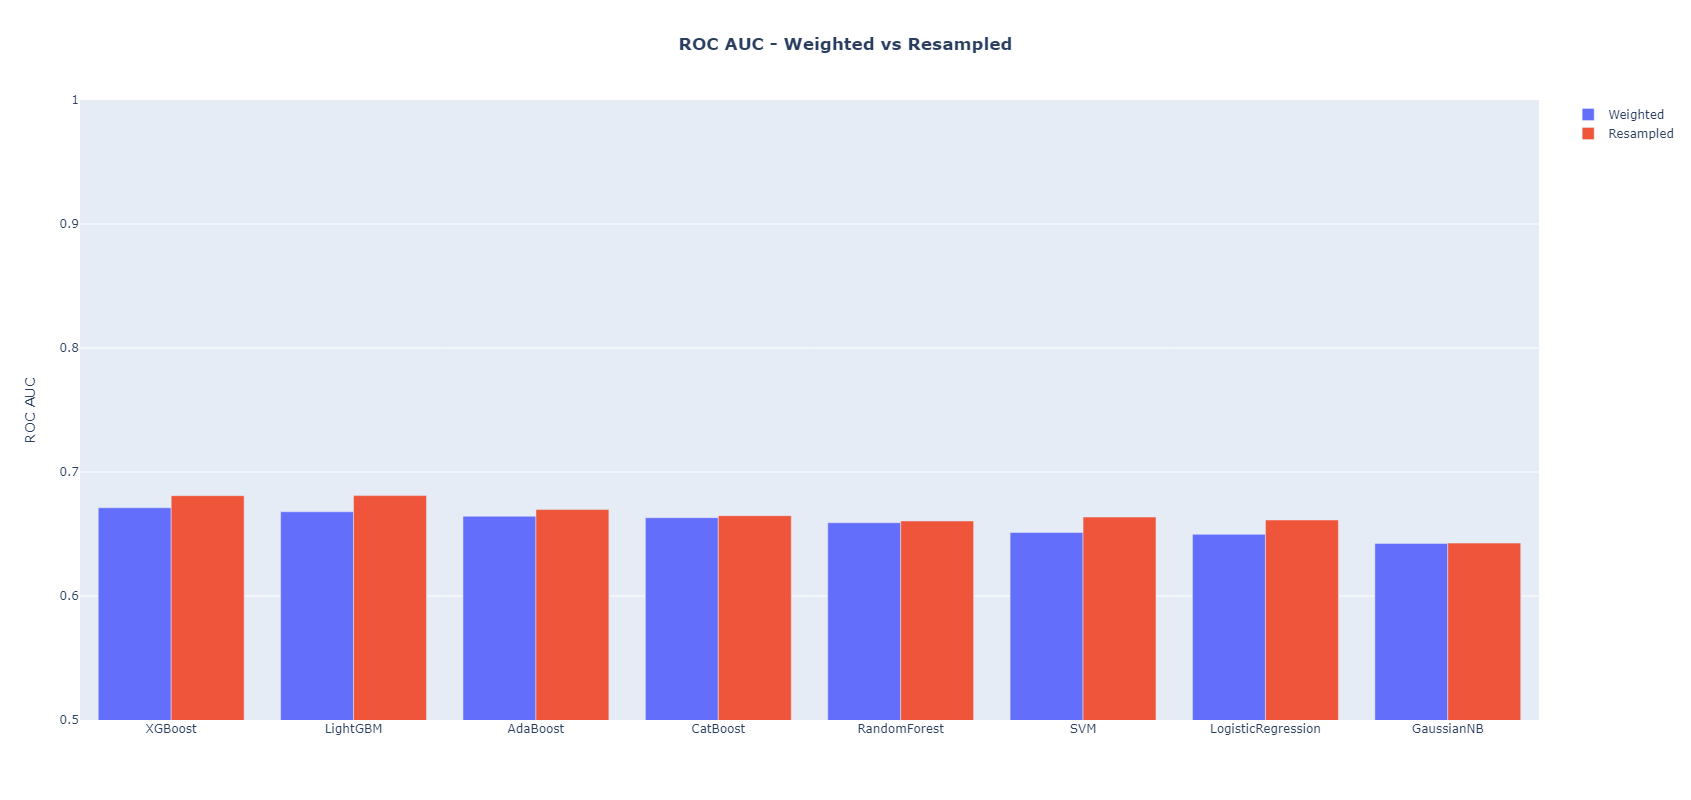

In [88]:
scores = pd.concat(
    [
        pd.DataFrame.from_dict(results["tuned"], orient="index"),
        pd.DataFrame.from_dict(results["tuned_resampled"], orient="index"),
    ],
    axis=1,
)

scores.columns = ["roc_auc", "params", "roc_auc_1", "params_1"]

scores = scores.sort_values(by="roc_auc", ascending=False)

fig = go.Figure(
    go.Bar(
        x=scores.index,
        y=scores.roc_auc,
        name="Weighted",
    )
)

fig.add_trace(
    go.Bar(
        x=scores.index,
        y=list(scores.roc_auc_1),
        name="Resampled",
    ),
)

fig.update_layout(
    barmode="group",
    title="<b>ROC AUC - Weighted vs Resampled</b>",
    title_x=0.5,
    yaxis_title="ROC AUC",
    yaxis=dict(range=(0.5, 1)),
    height=800,
    hovermode="x unified",
)

## Results

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

X_train = preprocess.fit_transform(X_train, y_train)
X_test = preprocess.transform(X_test)

In [103]:
model, params = model_builder(
    "XGBoost",
    y_train,
    weighted=True,
    params=results["tuned"]["XGBoost"]["params"],
)

In [50]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [104]:
model.fit(X_train, y_train, eval_set=eval_set, **params)

[0]	validation_0-logloss:0.69156	validation_1-logloss:0.69150
[1]	validation_0-logloss:0.69007	validation_1-logloss:0.69000
[2]	validation_0-logloss:0.68881	validation_1-logloss:0.68873
[3]	validation_0-logloss:0.68724	validation_1-logloss:0.68707
[4]	validation_0-logloss:0.68586	validation_1-logloss:0.68568
[5]	validation_0-logloss:0.68445	validation_1-logloss:0.68418
[6]	validation_0-logloss:0.68305	validation_1-logloss:0.68277
[7]	validation_0-logloss:0.68185	validation_1-logloss:0.68157
[8]	validation_0-logloss:0.68059	validation_1-logloss:0.68027
[9]	validation_0-logloss:0.67935	validation_1-logloss:0.67900
[10]	validation_0-logloss:0.67833	validation_1-logloss:0.67791
[11]	validation_0-logloss:0.67732	validation_1-logloss:0.67690
[12]	validation_0-logloss:0.67629	validation_1-logloss:0.67585
[13]	validation_0-logloss:0.67537	validation_1-logloss:0.67495
[14]	validation_0-logloss:0.67432	validation_1-logloss:0.67385
[15]	validation_0-logloss:0.67336	validation_1-logloss:0.67288
[1

XGBClassifier(alpha=6.61227216277674e-06, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.776972614081599, enable_categorical=False,
              eta=3.070048615655311e-05, gamma=6.214763219097096e-05, gpu_id=0,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=2.0599162968000703e-06,
              learning_rate=0.020397781208621006, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=196, n_jobs=16, normalize_type='forest',
              num_parallel_tree=1, predictor='auto', random_state=0,
              rate_drop=1.7246280761549113e-06, reg_alpha=6.61227205e-06,
              reg_lambda=2.05991637e-06, sample_type='uniform', ...)

In [53]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.676430512210773

In [54]:
with open("../dev/train/model_config.json", "w") as f:
    json.dump(
        {
            "model": {
                "XGBoost": model.get_params(),
            },
            "resampler": None,
        },
        f,
        indent=4,
    )